In [31]:
import psycopg2
import numpy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Apertura de la base de datos

In [32]:
conn = psycopg2.connect(database="centrotic", user="postgres",
                      password="raspberry", host="127.0.0.1",
                      port="5432")
cur = conn.cursor()

In [33]:
cur.execute("SELECT nfft, espectro, frec_central, frec_muestreo FROM radioastronomia_espectro WHERE (frec_central = 94000000 AND nfft=1024)")
rows = cur.fetchall()


In [34]:
nfft = rows[0][0]
espectro = rows[0][1]
frec_central = rows[0][2]
frec_muestreo = rows[0][3]

In [35]:
def promedio(espectro, nfft):
    K = int(len(espectro)/(nfft))
    x = numpy.zeros(nfft)
    for i in range(K):
        x = x + espectro[i*nfft:(i+1)*nfft]
    x = x/K
    return x

1024


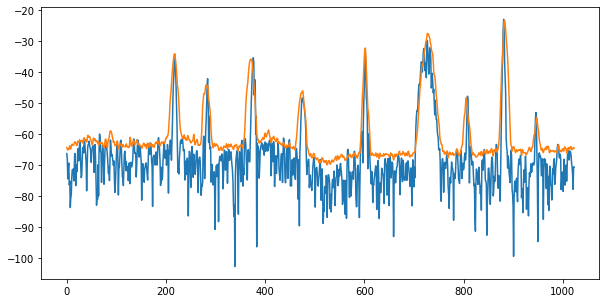

In [36]:
x = promedio(espectro, nfft)
plt.figure(figsize=(10,5))
plt.plot(espectro[0:nfft])
plt.plot(x)
print(nfft)

In [17]:
s = espectro[0:nfft]
for i in range(int(len(espectro)/nfft)-1):
    s = numpy.vstack((s, espectro[nfft*(i+1):nfft*(i+2)]))

In [18]:
df1 = pd.DataFrame(data=espectro)
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59392 entries, 0 to 59391
Data columns (total 1 columns):
0    59392 non-null float64
dtypes: float64(1)
memory usage: 464.1 KB


## querys para extraer barrido

seleccion de las frecuencias de muestreo, las frecuencias centrales
y el tamaño de la FFT, esto es para que el espectro seleccionado tenga las 
mismas características


In [19]:
cur.execute("SELECT DISTINCT frec_central FROM radioastronomia_espectro ORDER BY frec_central;")
rows = cur.fetchall()
frec_central = []
for row in rows:
    frec_central.append(row[0])

cur.execute("SELECT DISTINCT frec_muestreo FROM radioastronomia_espectro;")
rows = cur.fetchall()
frec_muestreo = []
for row in rows:
    print(row)
    frec_muestreo.append(row[0])

cur.execute("SELECT DISTINCT nfft FROM radioastronomia_espectro;")
rows = cur.fetchall()
nfft = []
for row in rows:
    nfft.append(row[0])

print("frecuencia muestreo {}".format(frec_muestreo))
print("frecuencia central {}".format(frec_central))
print("tamano FFT {}".format(nfft))

(8000000,)
(16000000,)
frecuencia muestreo [8000000, 16000000]
frecuencia central [82000000.0, 86000000.0, 90000000.0, 94000000.0, 98000000.0, 102000000.0, 408000000.0, 416000000.0, 424000000.0, 432000000.0, 440000000.0, 448000000.0, 456000000.0, 464000000.0, 472000000.0, 480000000.0, 488000000.0, 496000000.0]
tamano FFT [1024]


## seleccion de los tamaños de FFT

# Este es el generador de querys principal para crear el reporte

In [20]:
""" Esto hace un barrido de frecuencias """
df = pd.DataFrame(data=numpy.zeros(1024), columns=["X0"])
y = numpy.array([])
for frec_cen in frec_central:
    query = []
    query.append("SELECT espectro FROM radioastronomia_espectro ")
    query.append("WHERE (nfft = ")
    query.append(str(1024))
    query.append(" AND frec_muestreo = ")
    query.append(str(8000000))
    query.append(" AND frec_central = ")
    query.append(str(frec_cen))
    query.append(");")
    query = "".join(query)
    print(query)
            
    # extraccion del espectro
    cur.execute(query)
    rows = cur.fetchall()
    x_ = numpy.zeros(1024)
    for row in rows:
        espectro = row[0]
        espectro = numpy.asarray(espectro)
        x = promedio(espectro, 1024)
        x_ = x_ + x
    x_ = x_/len(rows)
    df[str(frec_cen)]=x_
    y = numpy.append(y, x_)
df = df.drop("X0", axis=1)

SELECT espectro FROM radioastronomia_espectro WHERE (nfft = 1024 AND frec_muestreo = 8000000 AND frec_central = 82000000.0);
SELECT espectro FROM radioastronomia_espectro WHERE (nfft = 1024 AND frec_muestreo = 8000000 AND frec_central = 86000000.0);
SELECT espectro FROM radioastronomia_espectro WHERE (nfft = 1024 AND frec_muestreo = 8000000 AND frec_central = 90000000.0);
SELECT espectro FROM radioastronomia_espectro WHERE (nfft = 1024 AND frec_muestreo = 8000000 AND frec_central = 94000000.0);
SELECT espectro FROM radioastronomia_espectro WHERE (nfft = 1024 AND frec_muestreo = 8000000 AND frec_central = 98000000.0);
SELECT espectro FROM radioastronomia_espectro WHERE (nfft = 1024 AND frec_muestreo = 8000000 AND frec_central = 102000000.0);
SELECT espectro FROM radioastronomia_espectro WHERE (nfft = 1024 AND frec_muestreo = 8000000 AND frec_central = 408000000.0);
SELECT espectro FROM radioastronomia_espectro WHERE (nfft = 1024 AND frec_muestreo = 8000000 AND frec_central = 416000000.0

/usr/lib/python3/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide


In [21]:
df.head()

,82000000.0,86000000.0,90000000.0,94000000.0,98000000.0,102000000.0,408000000.0,416000000.0,424000000.0,432000000.0,440000000.0,448000000.0,456000000.0,464000000.0,472000000.0,480000000.0,488000000.0,496000000.0
0,-63.202857,-64.649680,-66.473142,-64.345229,-62.503382,-63.078139,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-62.917964,-64.972734,-67.065043,-64.727432,-62.841219,-63.125228,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-61.909658,-65.348516,-67.029992,-65.183087,-62.772573,-62.247110,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-62.230684,-65.394271,-66.535063,-64.861920,-61.667972,-62.192581,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-62.175550,-64.275027,-66.172122,-64.884546,-61.707661,-63.051834,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
df.info()
f = numpy.linspace(78, 118, len(y))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1024 entries, 0 to 1023
Data columns (total 18 columns):
82000000.0     1024 non-null float64
86000000.0     1024 non-null float64
90000000.0     1024 non-null float64
94000000.0     1024 non-null float64
98000000.0     1024 non-null float64
102000000.0    1024 non-null float64
408000000.0    0 non-null float64
416000000.0    0 non-null float64
424000000.0    0 non-null float64
432000000.0    0 non-null float64
440000000.0    0 non-null float64
448000000.0    0 non-null float64
456000000.0    0 non-null float64
464000000.0    0 non-null float64
472000000.0    0 non-null float64
480000000.0    0 non-null float64
488000000.0    0 non-null float64
496000000.0    0 non-null float64
dtypes: float64(18)
memory usage: 144.1 KB


Text(0, 0.5, 'Espectro')

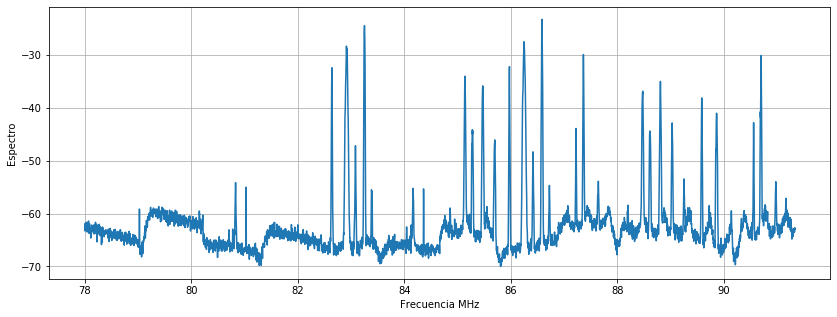

In [23]:
plt.figure(figsize=(14,5))
plt.plot(f, y)
plt.grid(True)
plt.xlabel("Frecuencia MHz")
plt.ylabel("Espectro")

## Analisis de las caracteristicas

In [26]:
query = "SELECT * FROM radioastronomia_caracteristicasespectro WHERE (id=6);"
cur.execute(query)
rows = cur.fetchall()

In [27]:
id = rows[0][0]
max_v = rows[0][1]
max_v = numpy.asarray(max_v)
min_v = rows[0][2]
min_v = numpy.asarray(min_v)
energia = rows[0][4]
energia = numpy.asarray(energia)
df = pd.DataFrame(data=numpy.array([10*numpy.log10(energia), min_v, max_v]).T, columns=["ener_", "min_", "max_"])

IndexError: list index out of range

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1024 entries, 0 to 1023
Data columns (total 18 columns):
82000000.0     1024 non-null float64
86000000.0     1024 non-null float64
90000000.0     1024 non-null float64
94000000.0     1024 non-null float64
98000000.0     1024 non-null float64
102000000.0    1024 non-null float64
408000000.0    0 non-null float64
416000000.0    0 non-null float64
424000000.0    0 non-null float64
432000000.0    0 non-null float64
440000000.0    0 non-null float64
448000000.0    0 non-null float64
456000000.0    0 non-null float64
464000000.0    0 non-null float64
472000000.0    0 non-null float64
480000000.0    0 non-null float64
488000000.0    0 non-null float64
496000000.0    0 non-null float64
dtypes: float64(18)
memory usage: 144.1 KB


In [29]:
df.describe()

,82000000.0,86000000.0,90000000.0,94000000.0,98000000.0,102000000.0,408000000.0,416000000.0,424000000.0,432000000.0,440000000.0,448000000.0,456000000.0,464000000.0,472000000.0,480000000.0,488000000.0,496000000.0
count,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,-62.527993,-65.232358,-63.725687,-60.825799,-60.333634,-62.022662,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,1.929990,1.749487,7.793552,8.911190,5.710435,5.125175,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,-68.187807,-69.787260,-69.479161,-69.991845,-67.760247,-69.672764,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,-64.015168,-66.327922,-66.734271,-65.921387,-62.989449,-64.401700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,-62.515960,-65.340897,-66.110804,-63.724841,-61.929591,-63.054670,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,-60.932301,-64.164760,-65.212904,-61.320363,-60.312309,-61.168385,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,-58.636542,-54.122946,-24.398841,-23.201706,-29.872811,-30.038553,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


/home/uis-e3t/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6721: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/home/uis-e3t/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6722: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


ValueError: autodetected range of [nan, nan] is not finite

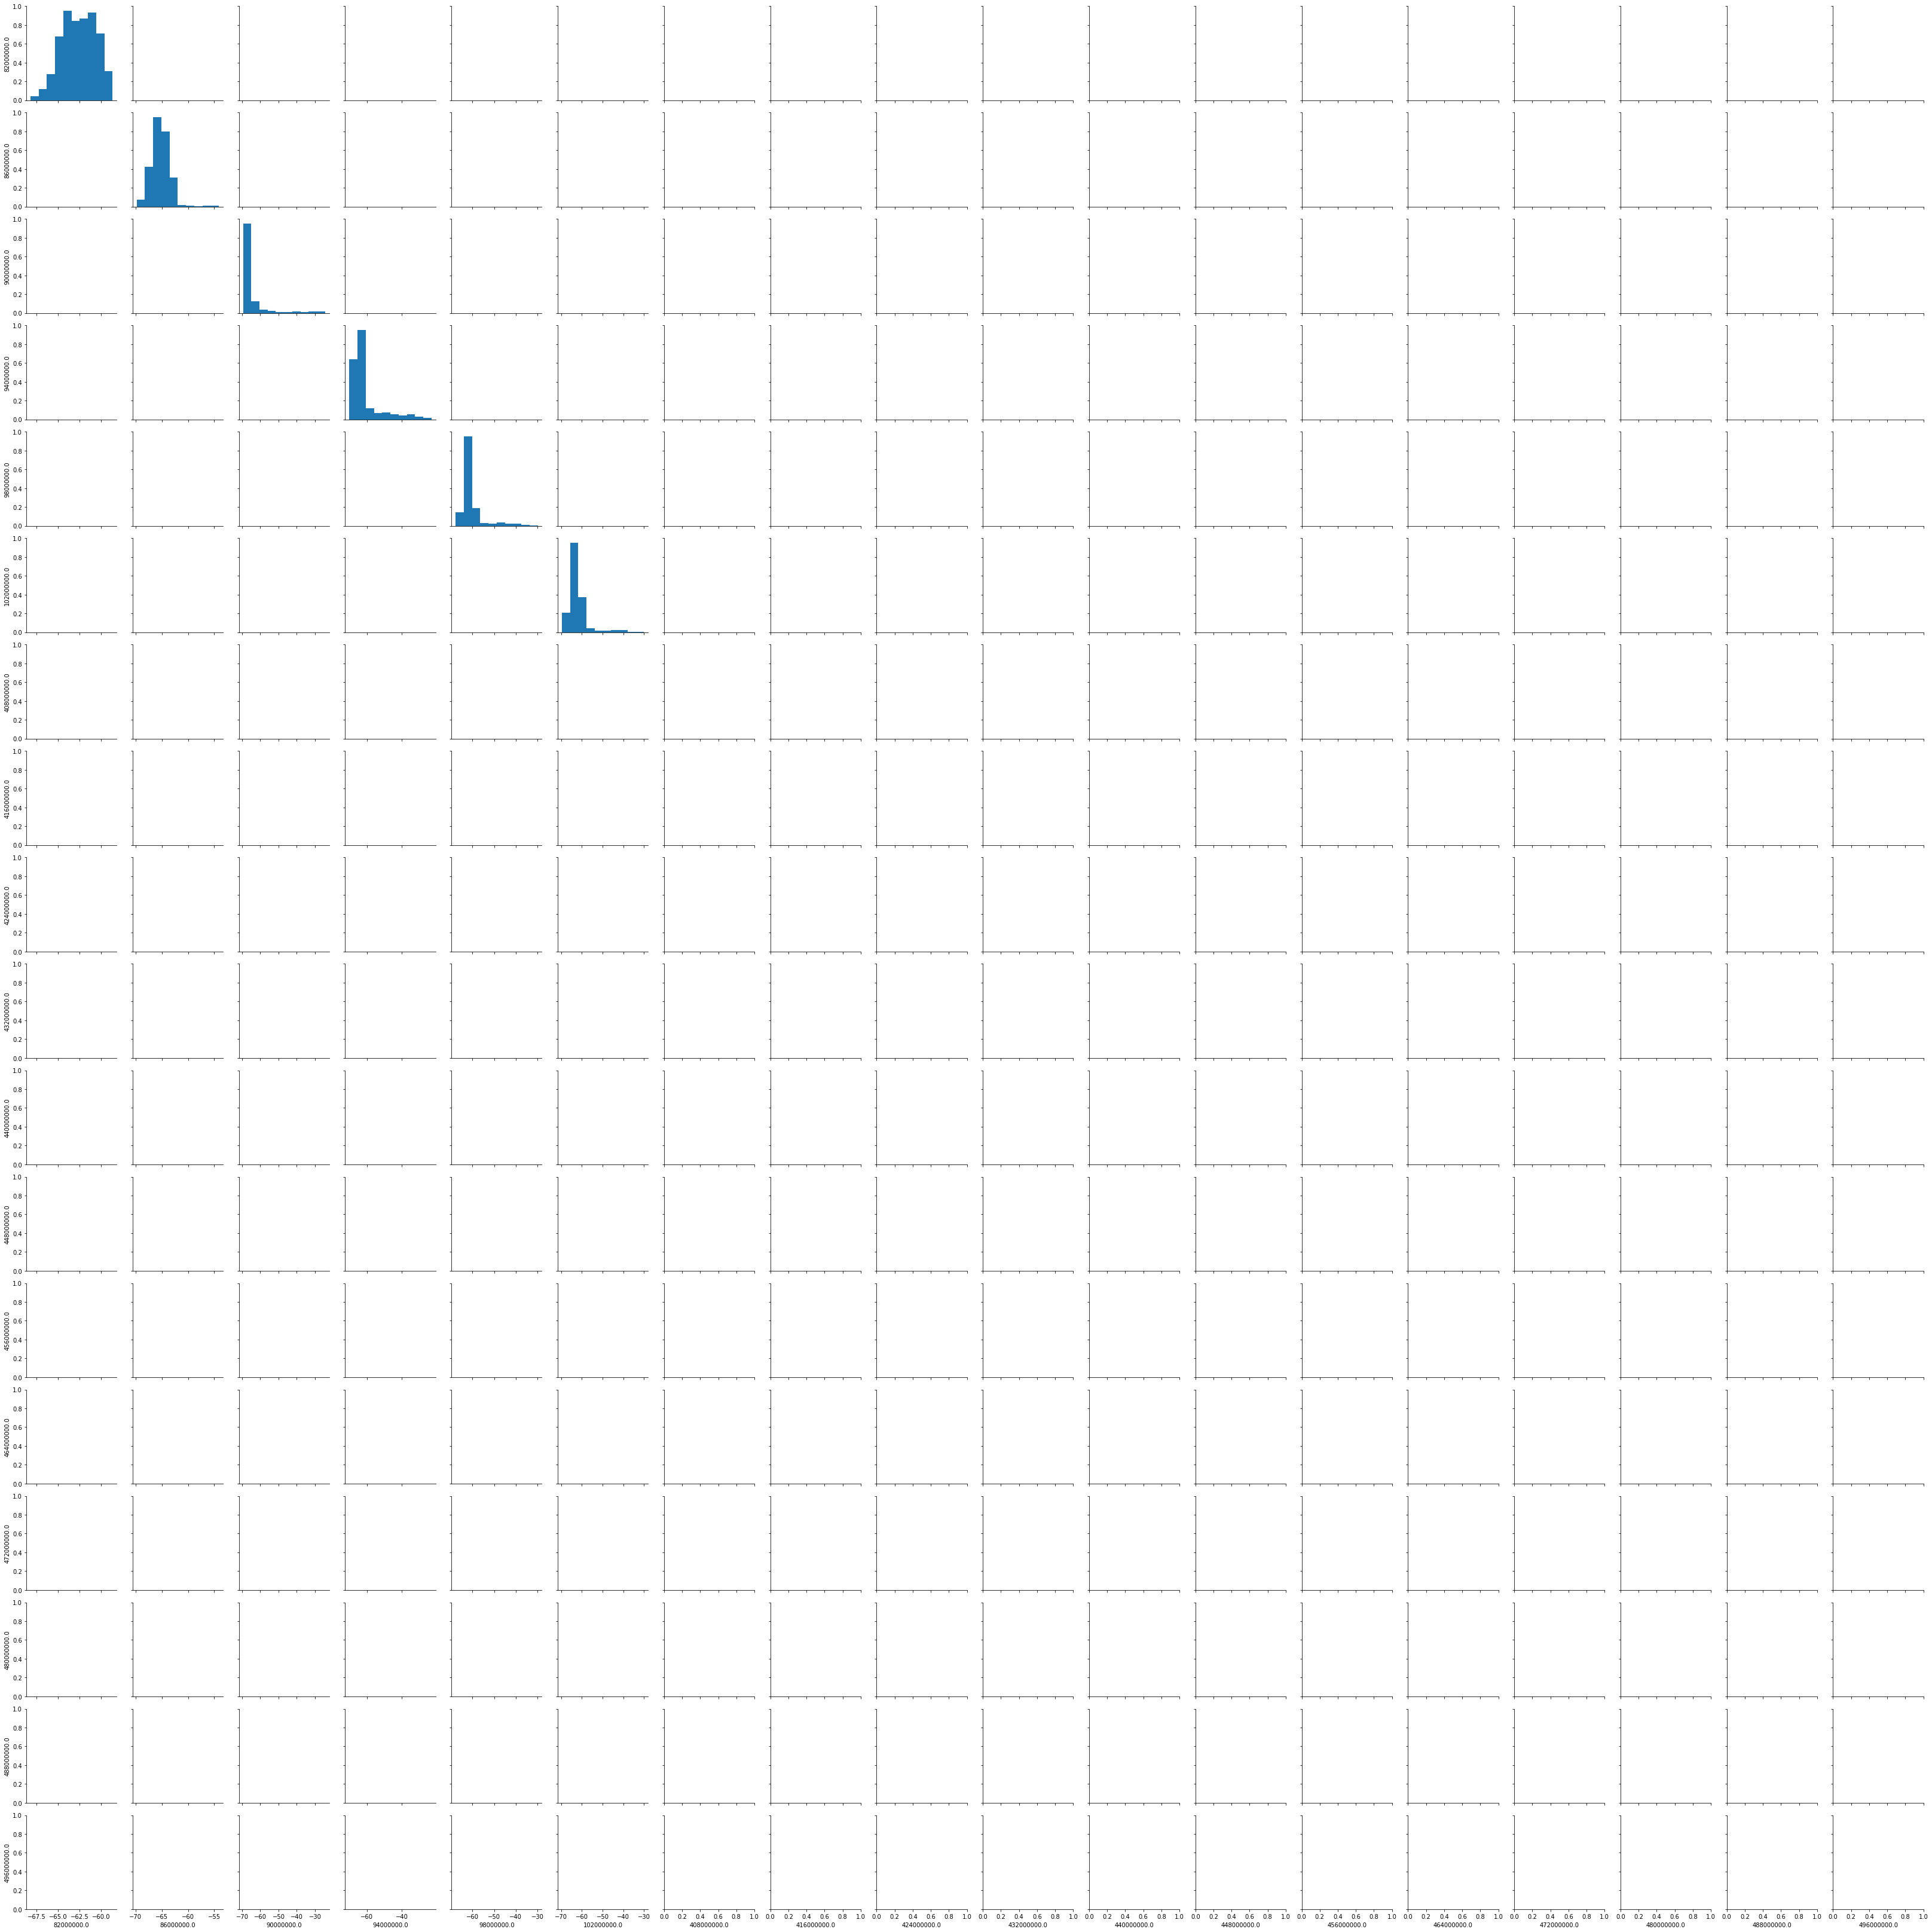

In [30]:
sns.pairplot(df)

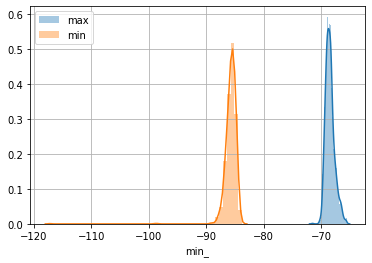

In [54]:
#sns.distplot(df["ener_"])
sns.distplot(df["max_"], label="max")
sns.distplot(df["min_"], label="min")
plt.grid(True)
plt.legend()